# Udacity Project 1

In [58]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display
from datetime import datetime
import plotly.express as px
from datetime import datetime as dt
from pandas_profiling import ProfileReport
import itertools
import plotly.graph_objects as go
from plotly.offline import iplot
import seaborn as sns
print('Import done.')

Import done.


In [2]:
df_listings = pd.read_csv(f"C:/develop/VSCode/Udacity/project_1/muc_listings.csv")
df_listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21641918,https://www.airbnb.com/rooms/21641918,20220921172344,2022-09-21,city scrape,Gemütliches helles Gästezimmer nahe München,Sehr schönes helles Zimmer im Dachgeschoß mit ...,NaN,https://a0.muscache.com/pictures/aafaf797-4be0...,20805795,...,4.97,4.85,4.93,NaN,f,1,0,1,0,1.98
1,14711185,https://www.airbnb.com/rooms/14711185,20220921172344,2022-09-21,city scrape,Mi casa es su casa,In unserer Wohnung mit einem gemütlichen Schla...,Es gibt viel Grün im Ort - viele Spielplätze u...,https://a0.muscache.com/pictures/8941737c-be2e...,56395839,...,4.41,4.06,4.59,NaN,f,1,0,1,0,0.26
2,20162448,https://www.airbnb.com/rooms/20162448,20220921172344,2022-09-21,city scrape,Shabby chic 30 minutes to Oktoberfest .,Shabby Chic 30 minutes from Oktoberfest. Share...,You`ll reach the pretty riverside of Isar with...,https://a0.muscache.com/pictures/25e4368a-7e06...,41482289,...,4.86,4.57,4.29,NaN,f,1,0,1,0,0.11
3,24837769,https://www.airbnb.com/rooms/24837769,20220921172344,2022-09-21,city scrape,Hohenbrunn(MUC)-Zuhause mit Aussicht und City ...,"Wunderschöne, große 2-Zimmer-Wohnung im Grünen...",Die Nachbarschaft ist sehr liebevoll und freun...,https://a0.muscache.com/pictures/fbb115cc-510e...,172211954,...,4.85,4.65,4.60,NaN,f,1,1,0,0,0.39
4,20900945,https://www.airbnb.com/rooms/20900945,20220921172344,2022-09-21,city scrape,Guesthouse at fasanenpark,(20 minutes to the Oktoberfest. The train stat...,NaN,https://a0.muscache.com/pictures/ac4f0d1b-b394...,150163486,...,4.97,4.83,4.72,NaN,f,1,0,1,0,0.49


In [8]:
df_cal = pd.read_csv(f"C:/develop/VSCode/Udacity/project_1/muc_calendar.csv")
df_cal.head()

df_cal.describe()

,listing_id,minimum_nights,maximum_nights
count,2.418520e+06,2.418519e+06,2.418519e+06
mean,2.324810e+17,7.439947e+00,2.590689e+06
std,3.231879e+17,2.627725e+01,7.453517e+07
min,9.794500e+04,1.000000e+00,1.000000e+00
25%,2.618678e+07,1.000000e+00,3.000000e+01
50%,4.368488e+07,2.000000e+00,3.650000e+02
75%,6.657236e+17,3.000000e+00,1.125000e+03
max,7.201332e+17,8.000000e+02,2.147484e+09


In [14]:
df_cal["date_new"] = pd.to_datetime(df_cal["date"], format="%Y-%m-%d")
df_cal["date_new"].min()

Timestamp('2023-09-21 00:00:00')

In [48]:
# Check that currency is always $
df_cal["currency"] = df_cal["price"].str[:1]
df_cal["currency"].unique()

# Check for decimals > always .00
df_cal["price_check"] = df_cal["price"].str[-3:]
df_cal["price_check"].unique()

# Cut decimals and replace $
df_cal["price_num"] = df_cal["price"].str[1:-3]
# df_cal["price_num"] = df_cal["price"].replace(".00", "TEST", inplace=False)
# df_cal["price_num"].astype(float)

df_cal["price_num"] = df_cal["price"].str[1:-3].apply(lambda x: x.replace(",", "")).astype(float)
df_cal["price_num"]

# Convert to float
# df_cal["price_num"] = df_cal["price"].str[1:].astype(float)
# df_cal.head(20)

0           52.0
1          120.0
2          120.0
3          120.0
4          120.0
           ...  
2418515     40.0
2418516     40.0
2418517     40.0
2418518     40.0
2418519     40.0
Name: price_num, Length: 2418520, dtype: float64

C:\Users\q514907\AppData\Local\Temp\ipykernel_28288\2878084938.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



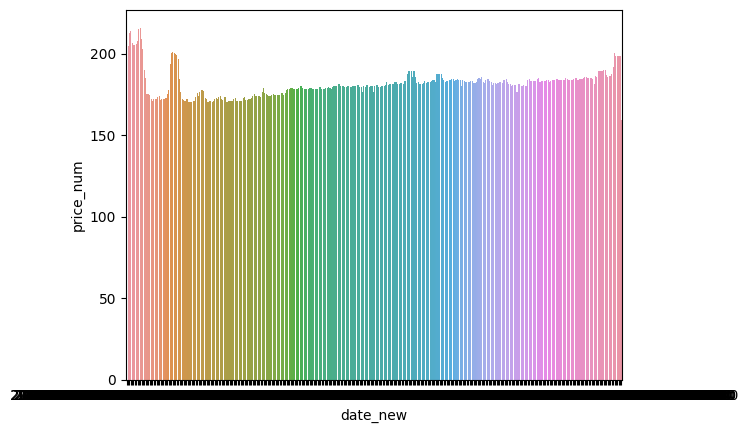

In [67]:
df_cal_grouped = df_cal.groupby(by=df_cal["date_new"]).mean()
df_cal_grouped = df_cal_grouped.reset_index()
df_cal_grouped["date_new"] = pd.to_datetime(df_cal_grouped["date_new"], format="%Y-%m-%d")

df_cal_grouped.head()

sns.barplot(data=df_cal_grouped, x="date_new", y="price_num")
plt.show()

listings_profile = ProfileReport(df_listings, title="Pandas Profiling Report")
listings_profile.to_file("your_report.html")

In [6]:
df_listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,6.627000e+03,6.627000e+03,6.627000e+03,6627.000000,6627.000000,0.0,6627.000000,6627.000000,6627.000000,0.0,...,4545.000000,4544.000000,4544.000000,4544.000000,4544.000000,6627.000000,6627.000000,6627.000000,6627.000000,4568.000000
mean,2.324482e+17,2.022092e+13,1.473340e+08,4.181832,5.745435,NaN,48.139378,11.564490,2.776068,NaN,...,4.718882,4.838726,4.851978,4.788305,4.641838,2.199940,1.407575,0.745134,0.024596,1.059153
std,3.232012e+17,0.000000e+00,1.497901e+08,31.864640,51.452315,NaN,0.027156,0.050215,1.574476,NaN,...,0.472875,0.393508,0.376740,0.346398,0.466774,3.840348,3.445977,2.052750,0.223502,1.829320
min,9.794500e+04,2.022092e+13,1.581000e+03,1.000000,1.000000,NaN,48.046030,11.351240,1.000000,NaN,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.619661e+07,2.022092e+13,2.113242e+07,1.000000,1.000000,NaN,48.122090,11.539834,2.000000,NaN,...,4.640000,4.830000,4.850000,4.710000,4.500000,1.000000,0.000000,0.000000,0.000000,0.180000
50%,4.368488e+07,2.022092e+13,8.734403e+07,1.000000,2.000000,NaN,48.136960,11.564820,2.000000,NaN,...,4.890000,4.980000,5.000000,4.890000,4.750000,1.000000,1.000000,0.000000,0.000000,0.500000
75%,6.656751e+17,2.022092e+13,2.460347e+08,2.000000,3.000000,NaN,48.155892,11.586770,4.000000,NaN,...,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,1.000000,1.000000,0.000000,1.180000
max,7.201332e+17,2.022092e+13,4.802791e+08,956.000000,1419.000000,NaN,48.252580,11.737896,16.000000,NaN,...,5.000000,5.000000,5.000000,5.000000,5.000000,33.000000,33.000000,26.000000,4.000000,51.440000


In [1]:
print("Hey, this works! :)")



Hey, this works! :)
